Necessary imports and settings

In [2]:
import glob
from PIL import Image
import numpy as np
import tensorflow as tf

dataFolder = "C:\\Users\\ariel\\OneDrive - Kennesaw State University\\Graduate School\\Fall 2023\\CS 7050 - AI and Robotics\\Group Project\\GroupProject - GitRepo\\nyu_data\\data"
inputImageSize = (256, 256)
batch_size = 32

data_loading_percentage = 20
trainTestSplit = 90

Loading data

In [3]:
imageSequences = glob.glob(dataFolder + "\\nyu2_train\\*")

validIndices = []
imageCount = 0

for imageSequence in imageSequences[0:int(len(imageSequences)*(data_loading_percentage/100))]:
    inputImages = glob.glob(imageSequence + "\\*.jpg")
    [validIndices.append(imageCount+j) for j in range(2, len(inputImages))]
    imageCount += len(inputImages)

In [4]:
def sortImages(inputList):
    return [x for _, x in sorted(zip([int(input[input.rfind("\\") + 1:-4]) for input in inputList], inputList))]

def print_progress_bar(iteration, total, prefix='', suffix='', length=25, fill='█'):
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end='\r')
    # Print New Line on Complete
    if iteration == total-1: 
        print("\n")


imageData = np.empty((imageCount, inputImageSize[0], inputImageSize[1], 3), dtype='int16')
depthData = np.empty((imageCount, inputImageSize[0], inputImageSize[1]), dtype='int16')


imageSequences = glob.glob(dataFolder + "\\nyu2_train\\*")
index = 0

for i, imageSequence in enumerate(imageSequences[0:int(len(imageSequences)*(data_loading_percentage/100))]):
    inputImages = sortImages(glob.glob(imageSequence + "\\*.jpg"))
    depthImages = sortImages(glob.glob(imageSequence + "\\*.png"))

    imageData[index:index+len(inputImages)] = [np.asarray(Image.open(file).resize(inputImageSize), dtype='int16') for file in inputImages]
    depthData[index:index+len(depthImages)] = [np.asarray(Image.open(file).resize(inputImageSize), dtype='int16') for file in depthImages]

    index += len(inputImages)

    print_progress_bar(i, len(imageSequences[0:int(len(imageSequences)*(data_loading_percentage/100))]))

 |████████████████████████-| 98.2% 



In [5]:
def data_generator(data, labels, validIndices, batch_size):
    while True:
        selectedIndices = np.random.choice(validIndices, batch_size)
        batch_data = np.asarray([np.asarray(data[index-2:index+1]) for index in selectedIndices])
        batch_labels = np.asarray([np.asarray(labels[index]) for index in selectedIndices])
        yield batch_data, batch_labels

data_generator(imageData, depthData, validIndices, 8)

<generator object data_generator at 0x0000023149E56F80>

In [6]:
dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(imageData, depthData, validIndices, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, imageData.shape[1]), dtype=tf.int16),
        tf.TensorSpec(shape=(batch_size,), dtype=tf.int16)
    )
)

# Configure for performance
dataset = dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [111]:
# def sortImages(inputList):
#     return [x for _, x in sorted(zip([int(input[input.rfind("\\") + 1:-4]) for input in inputList], inputList))]

# def print_progress_bar(iteration, total, prefix='', suffix='', length=25, fill='█'):
#     percent = ("{0:.1f}").format(100 * (iteration / float(total)))
#     filled_length = int(length * iteration // total)
#     bar = fill * filled_length + '-' * (length - filled_length)
#     print(f'\r{prefix} |{bar}| {percent}% {suffix}', end='\r')
#     # Print New Line on Complete
#     if iteration == total-1: 
#         print("\n")



# imageSequences = glob.glob(dataFolder + "\\nyu2_train\\*")

# inputImageData = np.array([])
# depthImageData = np.array([])
# validIndices = np.array([])

# for i, imageSequence in enumerate(imageSequences):
#     inputImages = sortImages(glob.glob(imageSequence + "\\*.jpg"))
#     depthImages = sortImages(glob.glob(imageSequence + "\\*.png"))

#     rawInputImageData = [np.asarray(Image.open(file).resize(inputImageSize), dtype='int16') for file in inputImages]
#     rawDepthImageData = [np.asarray(Image.open(file).resize(inputImageSize), dtype='int16') for file in depthImages]

#     inputImageData = np.concatenate(inputImageData, )
#     # rawInputImageSequence = [np.asarray(rawInputImageData[index-1:index+2]) for index in range(1, len(rawInputImageData)-1)]
#     # rawDepthImageForSequence = rawDepthImageData[1:len(rawDepthImageData)-1]

#     inputImageData.extend(rawInputImageData)
#     depthImageData.extend(rawDepthImageData)

#     print_progress_bar(i, len(imageSequences))

# inputImageData = np.asarray(inputImageData)
# depthImageData = np.asarray(depthImageData)

np.savetxt('inputImageData.csv', inputImageData, delimiter=',')
np.savetxt('depthImageData.csv', depthImageData, delimiter=',')


Print output shapes and show a sample of the data

(256, 256, 3)


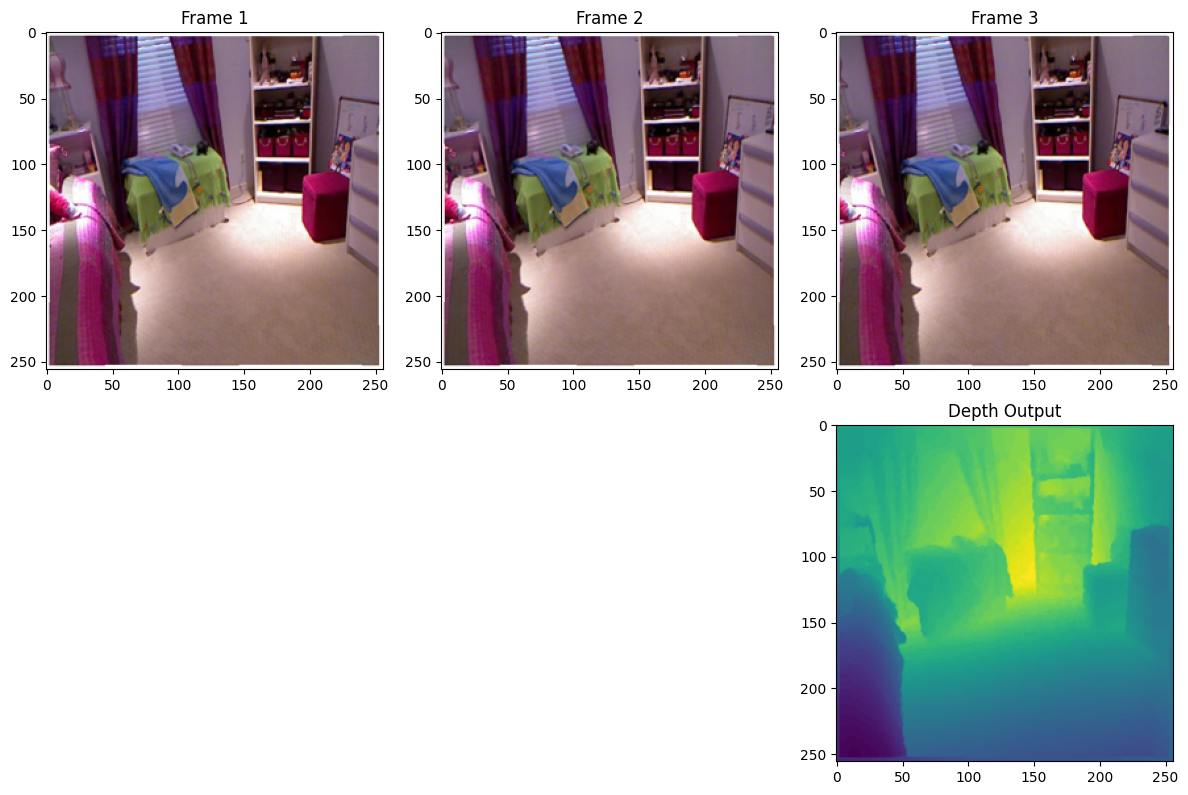

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

gen = data_generator(imageData, depthData, validIndices, 8)
sampleImages, sampleDepth = next(gen)
print(sampleImages[0][0].shape)

axes[0].imshow(sampleImages[0][0])
axes[0].set_title('Frame 1')
axes[1].imshow(sampleImages[0][1])
axes[1].set_title('Frame 2')
axes[2].imshow(sampleImages[0][2])
axes[2].set_title('Frame 3')
axes[5].imshow(sampleDepth[0])
axes[5].set_title('Depth Output')

for ax in axes[3:5]:
    ax.axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# importing libraries to run dnn

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Add, Activation, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

In [9]:
def hourglass_module(x, filters):
    # First Residual Block
    x_res1 = residual_block(x, filters)

    # Downsampling
    x_downsampled = MaxPooling2D((2, 2), padding='same')(x_res1)

    # Second Residual Block
    x_res2 = residual_block(x_downsampled, filters)

    # Upsampling
    x_upsampled = UpSampling2D((2, 2))(x_res2)

    # Skip connection to the original input
    x_skip = Conv2D(filters, (1, 1), padding='same')(x)

    # Resize x_upsampled to match the shape of x_skip_resized
    x_upsampled_resized = tf.image.resize(x_upsampled, size=tf.shape(x_skip)[1:3], method='nearest')

    # Skip connection with the upsampled features
    x = Add()([x_skip, x_upsampled_resized])

    return x

def residual_block(x, filters, kernel_size=3, strides=1):
    y = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    y = Activation('relu')(y)
    y = Conv2D(filters, kernel_size, padding='same')(y)

    # Adjust the shortcut connection to match the dimensions
    shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
    y = Add()([y, shortcut])

    y = Activation('relu')(y)
    return y

In [10]:
def encoder_decoder(input_shape, level_1_features=16, level_2_features=32, level_3_features=64):
    output_shape = input_shape[-1]
    # Input layer
    inputs = Input(shape=input_shape)

    # First convolution layer
    conv1 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(inputs)

    # Second convolution layer
    conv2 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(conv1)
#     conv2 = Activation('relu')(conv2)

    # Third convolution layer
    conv3 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(conv2)
#     conv3 = Activation('relu')(conv3)
    conv4Input = Add()([conv3, conv1])

    # Fourth convolution layer with a residual connection
    conv4 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(conv4Input)
#     conv4 = Activation('relu')(conv4)
    
    #Max pooling after conv4
    conv4_pooled = MaxPooling2D((2, 2))(conv4)

    # fifth convolution layer 
    conv5 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(conv4_pooled)
#     conv5 = Activation('relu')(conv5)
    
    # sixth convolution layer 
    conv6 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(conv5)
#     conv6 = Activation('relu')(conv6)
    
    conv7Input = Add()([conv6, conv4_pooled])
    
    # seventh convolution layer with a residual connection
    conv7 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(conv7Input)
#     conv7 = Activation('relu')(conv7)
    
    #Max pooling after conv7
    conv7_pooled = MaxPooling2D((2, 2), padding='same')(conv7)
    
    # eight convolution layer 
    conv8 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(conv7_pooled)
#     conv8 = Activation('relu')(conv8)
    
    # nineth convolution layer 
    conv9 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(conv8)
#     conv9 = Activation('relu')(conv9)
    
    conv10Input = Add()([conv9, conv7_pooled])
    
    #tenth convolutional layer with residual connection
    conv10 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(conv10Input)
#     conv10 = Activation('relu')(conv10)
    
    #max pooling after conv10
    conv10_pooled = MaxPooling2D((2, 2), padding='same')(conv10)
    
    #This needs to fed into the Hour Glass
    
#     hourGlass1Output = hourglass_module(conv10_pooled, 64)
       # Stacked Hourglass
    hourglass = conv10_pooled
    for _ in range(4):  # You can adjust the number of stacked hourglass modules
        hourglass = hourglass_module(hourglass, 128) 
        
    for _ in range(4):  # You can adjust the number of stacked hourglass modules
        hourglass = hourglass_module(hourglass, 128) 
        

    dec_conv1 = UpSampling2D((2, 2))(hourglass)
    
    dec_conv2 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(dec_conv1) # this output gets added to output of conv 4
    
    dec_conv3 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(dec_conv2)
    
    dec_conv4 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(dec_conv3)
    
    dec_conv5Input = Add()([dec_conv4, dec_conv2])
    
    dec_conv5 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(dec_conv5Input)
    dec_conv6 = UpSampling2D((2, 2))(dec_conv5) # add this to output of conv 8
    
    dec_conv7 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(dec_conv6)
    dec_conv8 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(dec_conv7)
    
    dec_conv9Input = Add()([dec_conv8, dec_conv6])
    
    dec_conv9 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(dec_conv9Input)
    dec_conv10 = UpSampling2D((2, 2))(dec_conv9) # add this to output of conv 12

    dec_conv11 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(dec_conv10)
    dec_conv12 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(dec_conv11)
    
    dec_conv13Input = Add()([dec_conv12, dec_conv10])

    dec_conv13 = Conv2D(output_shape, (3, 3), padding='same', activation='relu')(dec_conv13Input)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=dec_conv13)
    return model

# checking that the encoder_decoder is working

In [11]:
# Getting Model dimensions
input_shape = (256, 256, 3)  # Adjust input shape as needed
model = encoder_decoder(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

# Training the Model

In [38]:
# sampleImages.shape

# temp_sampleImages = sampleImages

# temp_sampleImages = temp_sampleImages[:, 0, :, :]

# temp_sampleImages.shape


(8, 256, 256, 3)

In [61]:
# sampleDepth.shape

# temp_sampleImages = sampleImages

# temp_sampleImages = temp_sampleImages[:, 0, :, :]
# # Assuming sampleDepth has shape (8, 256, 256)
# resized_sampleDepth = tf.expand_dims(sampleDepth, axis=-1)  # Add the missing dimension

# # Now sampleDepth has shape (8, 256, 256, 1)

# # Replicate the single channel across three channels
# resized_sampleDepth = tf.concat([resized_sampleDepth] * 3, axis=-1)

# # resized_sampleDepth = tf.image.resize(sampleDepth, (80, 80))

# resized_sampleDepth.shape


TensorShape([8, 256, 256, 3])

In [112]:
def preprocess_data(image_data, depth_data):

    temp_sample_images = image_data[:, 0, :, :]  # Slicing the tensor as per your requirement

    # Assuming depth_data has shape (batch_size, 256, 256)
    resized_sample_depth = tf.expand_dims(depth_data, axis=-1)  # Add the missing dimension

    # Now resized_sample_depth has shape (batch_size, 256, 256, 1)

    # Replicate the single channel across three channels
    resized_sample_depth = tf.concat([resized_sample_depth] * 3, axis=-1)

    return temp_sample_images, resized_sample_depth

In [12]:
iterator = iter(dataset)

epoch = 1
# Define the model
input_shape = (256, 256, 3)
model = encoder_decoder(input_shape)

gen = data_generator(imageData, depthData, validIndices, 8)

for epoch in range(epoch):
    try:
        while True:
            sampleImages, sampleDepth = next(gen)
            # temp_sampleImages, resized_sampleDepth =  preprocess_data(sampleImages, sampleDepth)
            temp_sample_images = sampleImages[:, 0, :, :]  # Slicing the tensor as per your requirement

            # Assuming depth_data has shape (batch_size, 256, 256)
            resized_sample_depth = tf.expand_dims(sampleDepth, axis=-1)  # Add the missing dimension

            # Now resized_sample_depth has shape (batch_size, 256, 256, 1)

            # Replicate the single channel across three channels
            resized_sample_depth = tf.concat([resized_sample_depth] * 3, axis=-1)

            # Compile the model
            model.compile(optimizer=Adam(), loss=MeanSquaredError())

            # Train the model
            model.fit(temp_sample_images, resized_sample_depth, epochs=10, batch_size=8, validation_split=0.2)

    except tf.errors.OutOfRangeError:
        # Dataset iteration is complete
        sampleImages, sampleDepth = next(gen)

Epoch 1/10
1/1 [==============================] - 13s 13s/step - loss: 4184.5640 - val_loss: 33442818.0000
Epoch 2/10
1/1 [==============================] - 0s 98ms/step - loss: 36331372.0000 - val_loss: 4866.7451
Epoch 3/10
1/1 [==============================] - 0s 100ms/step - loss: 4182.0254 - val_loss: 4851.4980
Epoch 4/10
1/1 [==============================] - 0s 104ms/step - loss: 4168.1890 - val_loss: 3623.2283
Epoch 5/10
1/1 [==============================] - 0s 102ms/step - loss: 3228.3997 - val_loss: 4796.9595
Epoch 6/10
1/1 [==============================] - 0s 102ms/step - loss: 4131.1089 - val_loss: 3978.4277
Epoch 7/10
1/1 [==============================] - 0s 104ms/step - loss: 3455.0281 - val_loss: 97467.0312
Epoch 8/10
1/1 [==============================] - 0s 110ms/step - loss: 105772.3984 - val_loss: 4899.5293
Epoch 9/10
1/1 [==============================] - 0s 102ms/step - loss: 4206.2861 - val_loss: 4901.8853
Epoch 10/10
1/1 [==============================] - 0s 1

: 

In [133]:
# # Define the model
# input_shape = (256, 256, 3)
# model = encoder_decoder(input_shape)



# # Compile the model
# model.compile(optimizer=Adam(), loss=MeanSquaredError())

# # Train the model
# model.fit(temp_sampleImages, resized_sampleDepth, epochs=10, batch_size=8, validation_split=0.2)

# # # Save the trained model
# # model.save("encoder_decoder_model.h5")

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 9024.6211 - val_loss: 5267.2471
Epoch 2/10
1/1 [==============================] - 0s 112ms/step - loss: 3327.8655 - val_loss: 13436782.0000
Epoch 3/10
1/1 [==============================] - 0s 115ms/step - loss: 17737944.0000 - val_loss: 6885.1313
Epoch 4/10
1/1 [==============================] - 0s 111ms/step - loss: 4622.8838 - val_loss: 7588.5664
Epoch 5/10
1/1 [==============================] - 0s 112ms/step - loss: 5225.5693 - val_loss: 7486.9429
Epoch 6/10
1/1 [==============================] - 0s 119ms/step - loss: 5122.6089 - val_loss: 6950.5562
Epoch 7/10
1/1 [==============================] - 0s 113ms/step - loss: 4663.7236 - val_loss: 5470.2559
Epoch 8/10
1/1 [==============================] - 0s 116ms/step - loss: 3377.3765 - val_loss: 2523.1819
Epoch 9/10
1/1 [==============================] - 0s 111ms/step - loss: 1371.3145 - val_loss: 10635.3027
Epoch 10/10
1/1 [==============================] - 0s 113m